# Imports

In [ ]:
import os
from pathlib import Path
import numpy as np
import torch
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Download

In [ ]:
import json
api_token = {"username": "x", "key": "y"} #
!mkdir -p ~/.kaggle/
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!ls -la /root/.kaggle/

total 16
drwxr-xr-x 2 root root 4096 Apr 22 19:19 .
drwx------ 1 root root 4096 Apr 22 19:19 ..
-rw------- 1 root root   73 Apr 22 19:19 kaggle.json


In [ ]:
!pwd

/content


In [ ]:
path = Path('/content/data')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/content/data')

In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset -p {path}

 95% 185M/195M [00:05<00:00, 28.9MB/s]
100% 195M/195M [00:05<00:00, 37.2MB/s]


In [ ]:
!unzip -q -n {path}/breast-ultrasound-images-dataset.zip -d {path}

In [ ]:
!ls '/content/data/Dataset_BUSI_with_GT'

benign	malignant  normal


In [ ]:
path = Path('/content/data/Dataset_BUSI_with_GT')

In [ ]:
fram_obj_train = {'img' : [], 'mask' : []}

In [ ]:
def Load_data( frame_obj=None, img_path=None, mask_path=None, shape=256):
    img_names = os.listdir(img_path)
    names = []
    mask_names = []
    unames = []
    for i in range(len(img_names)):
        unames.append(img_names[i].split(')')[0])
    unames = list(set(unames))
    for i in range(len(unames)):
        names.append(f"{unames[i]}).png")
        mask_names.append(f"{unames[i]})_mask.png")
    img_path = f"{img_path}/"
    mask_path = f"{mask_path}/"
    for i in range(len(names)):
        img = plt.imread(img_path + names[i])
        mask = plt.imread(mask_path + mask_names[i])
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frame_obj['img'].append(img)
        frame_obj['mask'].append(mask)
    return frame_obj

In [ ]:
fram_obj_train = Load_data(frame_obj=fram_obj_train, img_path=path/f'benign', 
                            mask_path=path/f'benign', shape=256)

In [ ]:
fram_obj_train = Load_data(frame_obj=fram_obj_train, img_path=path/f'malignant', 
                            mask_path=path/f'malignant', shape=256)

In [ ]:
fram_obj_train['img'][1].shape, fram_obj_train['mask'][1].shape

((256, 256, 3), (256, 256))

In [ ]:
len(fram_obj_train['img']), len(fram_obj_train['mask'])

(647, 647)

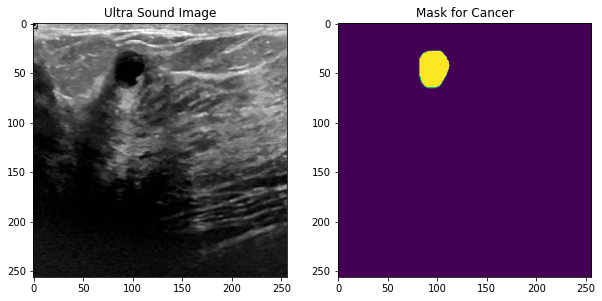

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.imshow(fram_obj_train['img'][1])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(fram_obj_train['mask'][1])
plt.title('Mask for Cancer')
plt.show()

In [ ]:
torch.unique(fram_obj_train['mask'][1])

In [ ]:
def Conv2dBlock(inputTensor, num_filters, kernel_size=3, batch_norm=True):
    # first Conv
    x = tf.keras.layers.Conv2D(filters=num_filters, 
        kernel_size=(kernel_size, kernel_size),
        kernel_initializer='he_normal', padding='same', 
        input_shape=inputTensor) (inputTensor) #, input_shape=inputTensor[1:]
    if batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    # second Conv
    x = tf.keras.layers.Conv2D(filters=num_filters, 
        kernel_size=(kernel_size, kernel_size),
        kernel_initializer='he_normal', padding='same') (x)
    if batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def build_unet(input_image, num_filters=16, dropouts=0.1, batch_norm=True):
    c1 = Conv2dBlock(input_image, num_filters * 1, kernel_size=3, batch_norm=batch_norm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(dropouts)(p1)

    c2 = Conv2dBlock(p1, num_filters * 2, kernel_size=3, batch_norm=batch_norm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(dropouts)(p2)

    c3 = Conv2dBlock(p2, num_filters * 4, kernel_size=3, batch_norm=batch_norm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(dropouts)(p3)

    c4 = Conv2dBlock(p3, num_filters * 8, kernel_size=3, batch_norm=batch_norm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(dropouts)(p4)

    c5 = Conv2dBlock(p4, num_filters * 16, kernel_size=3, batch_norm=batch_norm)

    u6 = tf.keras.layers.Conv2DTranspose(num_filters * 8, (3,3), strides=(2,2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(dropouts)(u6)
    c6 = Conv2dBlock(u6, num_filters * 8, kernel_size=3, batch_norm=batch_norm)

    u7 = tf.keras.layers.Conv2DTranspose(num_filters * 4, (3,3), strides=(2,2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropouts)(u7)
    c7 = Conv2dBlock(u7, num_filters * 4, kernel_size=3, batch_norm=batch_norm)

    u8 = tf.keras.layers.Conv2DTranspose(num_filters * 2, (3,3), strides=(2,2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropouts)(u8)
    c8 = Conv2dBlock(u8, num_filters * 2, kernel_size=3, batch_norm=batch_norm)

    u9 = tf.keras.layers.Conv2DTranspose(num_filters * 1, (3,3), strides=(2,2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropouts)(u9)
    c9 = Conv2dBlock(u9, num_filters * 1, kernel_size=3, batch_norm=batch_norm)

    output = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[input_image], outputs=[output])
    return model

# Model

In [ ]:
# learning rate 0.1
optimizer = tf.keras.optimizers.Adam(0.1)

In [ ]:
# inputs = tf.keras.layers.Input(shape=(256, 256, 3))
inputs = tf.keras.layers.Input(shape=(256, 256, 3), batch_size=32)
model = build_unet(inputs, dropouts=0.07)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

# Train

In [ ]:
x = fram_obj_train['img'][:640]
y = fram_obj_train['mask'][:640]

In [ ]:
# history = model.fit(np.array(fram_obj_train['img']), np.array(fram_obj_train['mask']), epochs=5, verbose=1,)
history = model.fit(np.array(x), np.array(y), epochs=50, verbose=1,)

Epoch 1/50
20/20 [==============================] - 16s 793ms/step - loss: 0.2151 - accuracy: 0.9451
Epoch 2/50
20/20 [==============================] - 16s 790ms/step - loss: 0.2035 - accuracy: 0.9455
Epoch 3/50
20/20 [==============================] - 16s 788ms/step - loss: 0.1876 - accuracy: 0.9491
Epoch 4/50
20/20 [==============================] - 16s 789ms/step - loss: 0.1769 - accuracy: 0.9504
Epoch 5/50
20/20 [==============================] - 16s 787ms/step - loss: 0.1648 - accuracy: 0.9531
Epoch 6/50
20/20 [==============================] - 16s 788ms/step - loss: 0.1608 - accuracy: 0.9519
Epoch 7/50
20/20 [==============================] - 16s 785ms/step - loss: 0.1497 - accuracy: 0.9550
Epoch 8/50
20/20 [==============================] - 16s 787ms/step - loss: 0.1505 - accuracy: 0.9524
Epoch 9/50
20/20 [==============================] - 16s 785ms/step - loss: 0.1387 - accuracy: 0.9569
Epoch 10/50
20/20 [==============================] - 16s 787ms/step - loss: 0.1316 - accura

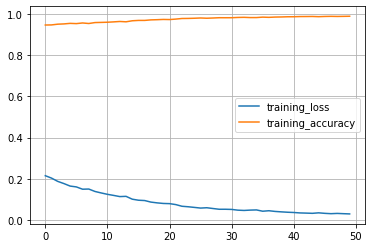

In [ ]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.legend()
plt.grid(True)

# Testing

In [ ]:
def predict16(valid_m, model, shape=256):
  img = valid_m['img'][0:32]
  mask = valid_m['mask'][0:32]
  img_proc = img[0:32]
  img_proc = np.array(img)
  preds = model.predict(img_proc)
  return preds, img_proc, mask

def Plotter(img, pred_mask, ground_through):
  plt.figure(figsize=(9,9))
  plt.subplot(1,3,1)
  plt.imshow(img)
  plt.title(' image')
  plt.subplot(1,3,2)
  plt.imshow(pred_mask)
  plt.title('Predicted mask')
  plt.subplot(1,3,3)
  plt.imshow(ground_through)
  plt.title('Actual mask')

In [ ]:
predictions, actuals, masks = predict16(fram_obj_train, model)

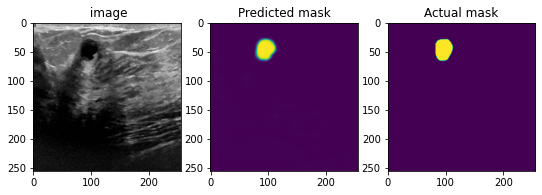

In [ ]:
Plotter(actuals[1], predictions[1][:,:,0], masks[1])